<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ダミー変数化と係数の仮説検定ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

エイムズの住宅販売価格予測を、線形回帰を使って行っていきます。

ここでは、これまで使っていなかったカテゴリ変数を説明変数として扱えるようにします。  
また、仮説検定を行うことで、線形回帰の結果の解釈性を高めます。

欠損値の処理などは線形回帰の時と同じとします。

In [ ]:
# Ames housing datasetを取得し、as_frame=Trueを指定してDataFrame形式で読み込む
housing = fetch_openml(name="house_prices", as_frame=True)

# DataFrameを表示
df = housing.frame

# 欠損値に意味がある場合の処理
df["PoolQC"] = df["PoolQC"].fillna("NA")
df["MiscFeature"] = df["MiscFeature"].fillna("NA")
df["Alley"] = df["Alley"].fillna("NA")
df["Fence"] = df["Fence"].fillna("NA")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NA")
df["GarageFinish"] = df["GarageFinish"].fillna("NA")
df["GarageQual"] = df["GarageQual"].fillna("NA")
df["GarageCond"] = df["GarageCond"].fillna("NA")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)
df["GarageType"] = df["GarageType"].fillna("NA")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NA")
df["BsmtCond"] = df["BsmtCond"].fillna("NA")
df["BsmtQual"] = df["BsmtQual"].fillna("NA")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NA")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NA")

# NeighbourhoodごとにLotFrontageの中央値を算出
platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()
# 同じ地区の中央値の値で埋める
df["LotFrontage"] = df.apply(
    lambda row: platform_neighbourhood_dict[row["Neighborhood"]]
    if np.isnan(row["LotFrontage"])
    else row["LotFrontage"],
    axis=1
)

# 欠損値の数を計算
chk_null2 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct2 = chk_null2 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl2 = pd.concat([chk_null2[chk_null2 > 0], chk_null_pct2[chk_null_pct2 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_new = chk_null_tbl2.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})

"""
"MasVnrArea	"カラム（組積造の面積）は
数値型なので中央値で欠損値処理
"MasVnrType"カラム（組積造の種別）と"Electrical"カラム（電気システムの種類）は
名義型なので最頻値で欠損値処理
"""

# 欠損値の数を計算し、0以外のカラムのインデックスを抽出
nonzero_columns = chk_null_tbl_new.index

# 欠損値を埋める処理
for column in nonzero_columns:
    if np.issubdtype(df[column].dtype, np.number):
        # 数値型の場合は中央値で埋める
        df[column].fillna(df[column].median(), inplace=True)
    else:
        # 文字型の場合は最頻値で埋める
        df[column].fillna(df[column].mode()[0], inplace=True)

# データ型を適切なタイプに変換
df['YrSold'] = df['YrSold'].astype(str)  # 売れた年
df['MoSold'] = df['MoSold'].astype(str)  # 売れた月
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)  # ガレージが建てられた年
df['YearBuilt'] = df['YearBuilt'].astype(str)  # 建築された年
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)  # リフォームされた年
df['MSSubClass'] = df['MSSubClass'].astype(str)  # 建物クラス（建てられ方の違い）

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-2-b15dfc9397c0>:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()


In [ ]:
# 欠損値の数を計算
chk_null3 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct3 = chk_null3 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl3 = pd.concat([chk_null3[chk_null3 > 0], chk_null_pct3[chk_null_pct3 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_end = chk_null_tbl3.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl_end

,欠損レコード数,欠損割合


すべての欠損値を埋めることができました。

## カテゴリ変数のダミー変数化

すべてのカテゴリ変数をダミー変数化してみます。  
カラム数を比較してみましょう。

In [ ]:
print(f"ダミー変数化前のカラム数：{len(df.columns)}")
df_dummies = pd.get_dummies(df, drop_first=True)
print(f"ダミー変数化後のカラム数：{len(df_dummies.columns)}")

ダミー変数化前のカラム数：81
ダミー変数化後のカラム数：552


カラム数が大幅に増加しました。

今回は特に、**住居基礎の種類**（ブリックタイル、軽量コンクリートブロックなど）を意味する  
**"Foundation"**カラムに注目します。

In [ ]:
df["Foundation"].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

ユニークな値が6つあるようです。

ダミー変数化後、どのようなカラムができたのか確認してみましょう。

In [ ]:
# "Foundation"から始まるカラム名を取得
foundation_columns = [col for col in df_dummies.columns if col.startswith('Foundation')]

# 結果を表示
print(foundation_columns)

['Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood']


ダミー変数トラップ（参考：[こちら](https://datawokagaku.com/one_hot_encoding/#i-2)）の影響で、カラム数が5つとなっています。

5つのカラム全ての値が0のデータは、"Foundation"カラムの値が"BrkTil"となります。

## そのほかのデータの加工

ヒノマルクさんの記事群(リンクは[こちら](https://www.hinomaruc.com/tag/ames/?order=asc))にもありますが、  
ほかにも以下のような加工をすることで、モデルの精度向上が期待できます。



- 外れ値処理

  - 外れ値かどうかを判断して除外するかどうかを検討する。

- 特徴量エンジニアリング

  - 新しい意味を持つ変数を作成する。
  - より説明力がある変数が作成できたり、変数の数を減らせる可能性がある。
  
- 変数選択

  - モデリングに必要なさそうな変数は除外する。
  - 計算量を減らせたり多重共線性を防げる可能性がある。

ヒノマルクさんの[こちら](https://www.hinomaruc.com/ames-dataset-analytics-3-1/)の記事を参考にしました。

## 住宅価格を重回帰分析で予測

いよいよ住宅価格の予測に入ります。

### 変数の選択

"SalePrice"カラム（住宅価格）とほかのカラムの相関係数を求めます。

相関係数が高かったカラムを重回帰分析に使うカラムとして採用します。

In [ ]:
# 相関行列の計算
correlation = df_dummies.corr()

# SalePriceとの相関係数の降順にソート
price_corr = correlation['SalePrice'].sort_values(ascending=False)

# 相関係数の表示
pd.DataFrame(price_corr).head(10)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
Foundation_PConc,0.497734


ここでは、相関係数の高かった以下の10つのカラムを  
**説明変数**として採用することにします。

In [ ]:
# "SalePrice"と相関係数の高かったカラム
columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "GarageArea",  # 地上全ての住宅面積（地下室は除く）
    "TotalBsmtSF",  # 全地下室の面積
    "1stFlrSF",  # 1Fの面積
    "FullBath",  # フル・バスルームの数（地下室は除く）
    "TotRmsAbvGrd",  # 総部屋数 (バスルーム、地下室は除く))
    "Foundation_PConc"  # 住居基礎の種類が"Pconc"かどうか
]

new_df = df_dummies[columns]

では、相関表のヒートマップを見てみましょう。

<Axes: >

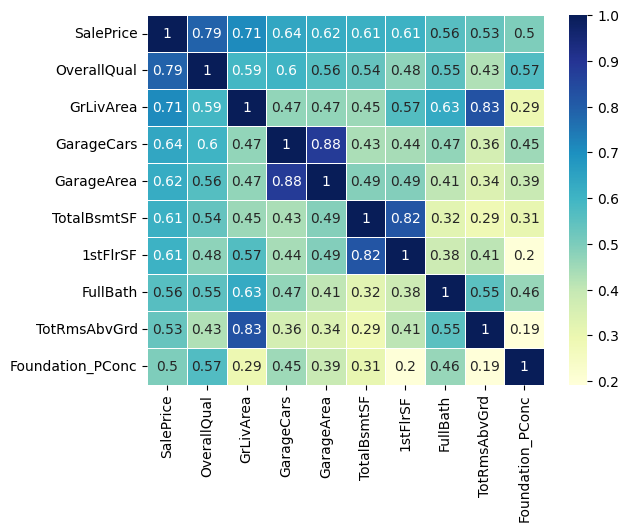

In [ ]:
sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)

多重共線性を考慮して、カラムをさらに絞ります。

ここで、相関が高くなってしまっている説明変数のペアのうち、  
目的変数"SalePrice"との相関がより高い説明変数を残すことにします。


In [ ]:
selected_columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "TotalBsmtSF",  # 全地下室の面積
    "FullBath",  # フル・バスルームの数（地下室は除く）
    "Foundation_PConc"  # 住居基礎の種類が"Pconc"かどうか
]

new_df = df_dummies[selected_columns]

では、相関表のヒートマップを見てみましょう。

<Axes: >

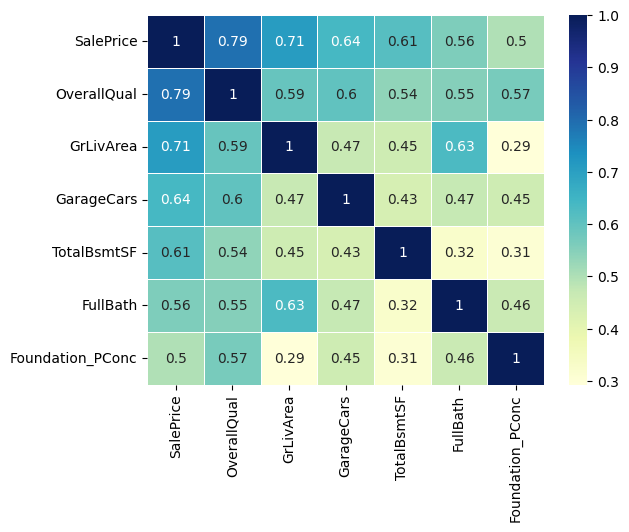

In [ ]:
sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)

### 学習

データを訓練用とテスト用に分けて、学習を行います。

In [ ]:
# 目的変数に"SalePrice"、説明変数にそれ以外の6つのカラムを指定
x = new_df.drop('SalePrice', axis=1)
y = new_df['SalePrice']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

# モデルの初期化と学習
model = LinearRegression()
model.fit(x_train_scaled, y_train)

LinearRegression()

最後に、パラメータを確認します。

In [ ]:
# intercept  切片
print(model.intercept_)

180586.22896281802


In [ ]:
# coefficient  係数
print(pd.Series(model.coef_, index=x.columns))

OverallQual         27345.958291
GrLivArea           27331.031639
GarageCars          11717.047776
TotalBsmtSF         17234.160934
FullBath            -1270.289694
Foundation_PConc     4808.191542
dtype: float64


### 評価

最後に、決定係数を用いてモデルの精度を評価します。

In [ ]:
# 学習データの平均と標準偏差を使って標準化する
x_test_scaled = scaler.transform(x_test)

print('訓練データに対する決定係数：', model.score(x_train_scaled, y_train))
print('テストデータに対する決定係数：', model.score(x_test_scaled, y_test))

訓練データに対する決定係数： 0.7851883674202385
テストデータに対する決定係数： 0.7077433338859396


カテゴリ変数をダミー変数化する前（"Foundation_PConc"カラムを学習に使う前）では、  
決定係数は以下のような結果となりました。

![](https://imgur.com/S9fSGvO.png)

わずかですが、テストデータに対する決定係数が上がったことが確認できます。

## 係数の仮説検定

以下の帰無仮説と対立仮説の元、係数の仮説検定を行います。

$$
t=\frac{\hat{\theta_j}-0}{SE(\hat{\theta_j})}
$$

- 以下のt値が自由度$m−n−1$($m$:データ数，$n$:特徴量数)のt分布に従う
- $\hat{\theta_j}$：線形回帰から得られた$j$番目の特徴量の係数
- $SE(\hat{\theta_j})$：$\hat{\theta_j}$の標準誤差(standard error)



帰無仮説：$\theta_j=0$  
対立仮説：$\theta_j\neq0$

In [ ]:
X = new_df.drop('SalePrice', axis=1)
y = new_df['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sma.add_constant(X_scaled)
est = sma.OLS(y, X_scaled)
est_trained = est.fit()
print(est_trained.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     781.3
Date:                Sun, 17 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:22:15   Log-Likelihood:                -17492.
No. Observations:                1460   AIC:                         3.500e+04
Df Residuals:                    1453   BIC:                         3.503e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.809e+05   1013.410    178.527      0.0

"FullBath"(="x5")カラムのみ、p値が0.05を上回っているので、  
帰無仮説を棄却することができません。

そのため、"FullBath"の値は'SalePrice'の予測には不要であるということが分かりました。

### 変数の選択

係数の仮説検定の結果を踏まえて、"FullBath"カラムを除いた形で改めて学習を行います。

In [ ]:
selected_columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "TotalBsmtSF",  # 全地下室の面積
    "Foundation_PConc"  # 住居基礎の種類が"Pconc"かどうか
]

new_df2 = df_dummies[selected_columns]

### 学習

In [ ]:
# 目的変数に"SalePrice"、説明変数にそれ以外の6つのカラムを指定
x = new_df2.drop('SalePrice', axis=1)
y = new_df2['SalePrice']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

# モデルの初期化と学習
model = LinearRegression()
model.fit(x_train_scaled, y_train)

LinearRegression()

### 評価

In [ ]:
# 学習データの平均と標準偏差を使って標準化する
x_test_scaled = scaler.transform(x_test)

print('訓練データに対する決定係数：', model.score(x_train_scaled, y_train))
print('テストデータに対する決定係数：', model.score(x_test_scaled, y_test))

訓練データに対する決定係数： 0.785056116959728
テストデータに対する決定係数： 0.7080340653727235
